# MDM imaging analysis

In [1]:
# load modules
from scipy.stats import stats
import scipy.io as spio
import pandas as pd
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from nilearn.input_data import NiftiMasker
import nilearn.plotting as plotting
from nilearn.image import mean_img
import pickle
import pandas as pd
import seaborn as sns 

%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


Autosaving every 5 seconds


## Rename task number to run number.

In [37]:
# data_root = '/home/rj299/project/mdm_analysis/data_rename'
data_root = 'D:\Ruonan\Projects in the lab\MDM Project\Medical Decision Making Imaging\MDM_imaging\Imaging Analysis\data_rename'

In [101]:
# functions for changing file names

# rename all files by adding run number determined by session and task number during scanning
def addRunNum(directory): 
    """ Add scan run numbers to file name
    
    Parameters
    --------------
    directory: directory for a subject, contains data for all runs
    
    """
    os.chdir(directory)
    
    # get sorted task number from the directory
    task_num_all = getTaskNum(directory)
    
    # add run number and rename
    for filename in os.listdir(directory):
        # get task number
        task_num = int(filename.split('_task-task')[1].split('_')[0])
        
        # get the run number based on all the task number in the directory
        run_count = task_num_all.index(task_num) + 1

        
        filename_new = filename.split('_task-task%s' %task_num)[0] + '_run-%s' %run_count + filename.split('_task-task%s' %task_num)[1]

        os.rename(filename, filename_new)  
        print(filename_new)

# get all task numbers for ses one
def getTaskNum(directory):
    """ Get all the task number for a session
     
    Parameters
    -----------------
    directory: data directory for a subject
    
    Return
    -----------------
    task_num: sorted task number for each session
    """
    file_ses = glob.glob('sub-*_ses-1_task*_bold.nii.gz')
    
    task_num = []
    
    for file in file_ses:
        task_id = file.split('_task-task')[1].split('_space')[0]
        task_num.append(int(task_id))
    
    task_num.sort()
    
    return task_num

In [39]:
# get all subjects folder
# sub_fold = glob.glob(data_root + '/sub-*')
sub_fold = glob.glob(data_root + '\\sub-*')

# get all subject id
sub_num = [] 
for fold in sub_fold:
    sub_id = fold.split('sub-')[1]
    sub_num.append(int(sub_id))
    
sub_num.sort()
print('All subjects included in analysis:', sub_num)

All subjects included in analysis: [2073, 2588, 2598]


The following two sections change the file names and only need running ONCE.

In [108]:
# rename files and add run number in the file name
# needs running only ONCE

# for fold in sub_fold:
#     if fold != '/home/rj299/project/mdm_analysis/data_rename/sub-2582':
#         addRunNum(fold)

In [114]:
# rename files and add run number in the file name
# subject 2582 only, because the files are named in a different way
# rename all files by adding run number determined by session and task number during scanning

# run ONLY ONCE

# def addRunNum_2582(directory): 
#     """ Add scan run numbers to file name
    
#     Parameters
#     --------------
#     directory: directory for a subject, contains data for all runs
    
#     """
#     os.chdir(directory)
    
#     # get sorted task number from the directory
#     task_num_all = getTaskNum_2582(directory)
    
#     # add run number and rename
#     for filename in os.listdir(directory):
#         # get task number
#         task_num = int(filename.split('_task-')[1].split('_')[0])
        
#         # get the run number based on all the task number in the directory
#         run_count = task_num_all.index(task_num) + 1

        
#         filename_new = filename.split('_task-%s' %task_num)[0] + '_run-%s' %run_count + filename.split('_task-%s' %task_num)[1]

#         os.rename(filename, filename_new)  
#         print(filename_new)

# # get all task numbers for ses one
# def getTaskNum_2582(directory):
#     """ Get all the task number for a session
    
#     Parameters
#     -----------------
#     directory: data directory for a subject
    
#     Return
#     -----------------
#     task_num: sorted task number for each session
#     """
#     file_ses = glob.glob('sub-*_ses-1_task*_bold.nii.gz')
    
#     task_num = []
    
#     for file in file_ses:
#         task_id = file.split('_task-')[1].split('_space')[0]
#         task_num.append(int(task_id))
    
#     task_num.sort()
    
#     return task_num

# addRunNum_2582(os.path.join(data_root, 'sub-2582'))

## Load anatomical data

In [43]:
# data_root = '/home/rj299/project/mdm_analysis/data_rename'
# out_root = '/home/rj299/project/mdm_analysis/output'

data_root = 'D:\Ruonan\Projects in the lab\MDM Project\Medical Decision Making Imaging\MDM_imaging\Imaging Analysis\data_rename'
out_root = 'D:\Ruonan\Projects in the lab\MDM Project\Medical Decision Making Imaging\MDM_imaging\Imaging Analysis\output'

In [45]:
def load_anat(sub):
    """ Load single subject anatomical data
    
    Parameters:
    ----------
    sub: subject id
    
    Retrun:
    ----------
    
    """
    
    anat_in = os.path.join(data_root, 'anat', 'sub-%s' %sub, 'sub-%s_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz' %sub)
    anat = nib.load(anat_in)
    
    return anat

In [49]:
# load all subjects' anatomical data
anat = []
for sub in sub_num:
    anat.append(load_anat(sub))

# average
anat_mean = mean_img(anat)

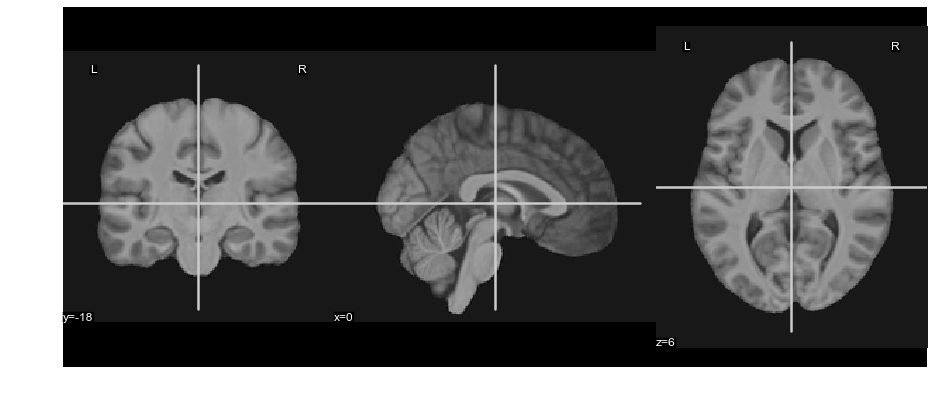

In [50]:
fig = plt.figure(figsize = (12,5))
plotting.plot_anat(anat_mean, black_bg = True, figure = fig)

3


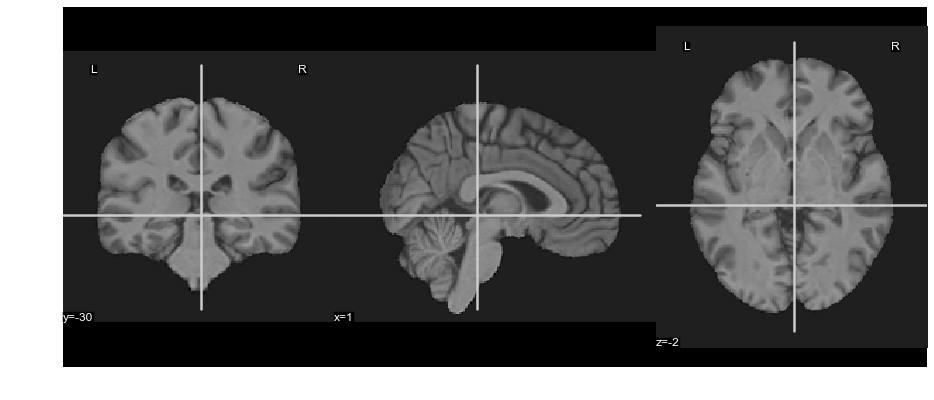

In [51]:
print(len(anat))

# single subject anatomical plot
fig = plt.figure(figsize = (12,5))
plotting.plot_anat(anat[0], black_bg = True, figure = fig)

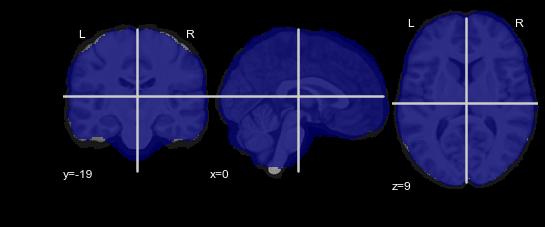

In [54]:
mask_whb = load_whb_mask(2073,2)
plotting.plot_roi(mask_whb, bg_img = anat_mean)

## Create design matrix from behavioral log

In [2]:
# data_behav_root = '/home/rj299/project/mdm_analysis/data_behav'
data_behav_root = 'D:\Ruonan\Projects in the lab\MDM Project\Medical Decision Making Imaging\MDM_imaging\Behavioral Analysis\PTB Behavior Log'


In [3]:
# subjects for imaging analysis
sub_num = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 2593, 2594, 2596, 2597, 2598, 2600, 2624, 2650, 2651, 2652, 2653, 2655, 2656, 2657, 2659, 2660, 2662, 2663, 2664, 2665, 2666]

In [4]:
sub_num

[2073,
 2550,
 2582,
 2583,
 2584,
 2585,
 2588,
 2592,
 2593,
 2594,
 2596,
 2597,
 2598,
 2600,
 2624,
 2650,
 2651,
 2652,
 2653,
 2655,
 2656,
 2657,
 2659,
 2660,
 2662,
 2663,
 2664,
 2665,
 2666]

In [ ]:
for sub_id in sub_num:
    

In [5]:
sub_id = 2073
mat_med_name = os.path.join(data_behav_root, 'subj%s' %sub_id, 'MDM_MED_%s.mat' %sub_id)

In [6]:
mat_med_name

'D:\\Ruonan\\Projects in the lab\\MDM Project\\Medical Decision Making Imaging\\MDM_imaging\\Behavioral Analysis\\PTB Behavior Log\\subj2073\\MDM_MED_2073.mat'

In [7]:
def _todict(matobj):
    '''
    Author: Or
    
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def _check_keys(dict):
    '''
    Author: Or
    
    checks if entries in dictionary are mat-objects. If yes todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict 

def loadmat(filename):
    '''
    Author: Or
    
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    
    from: `StackOverflow <http://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries>`_
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [8]:
behav_med = loadmat(mat_med_name)

In [9]:
list(behav_med.keys())[3]

'Datamed'

In [10]:
behav_med['Datamed'].keys()

dict_keys(['observer', 'date', 'refSide', 'filename', 'stimulus', 'colorKey', 'numTrials', 'block', 'vals', 'probs', 'ambigs', 'colors', 'ITIs', 'trialTime', 'choice', 'rt', 'Summary'])

In [11]:
choice = behav_med['Datamed']['choice']
print(choice)
print(choice.shape)

[2 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 1 2 2 1 2 2 2 2 1 1 2 2 1 2 1 2 2 2
 2 1 1 1 2 2 1 1 1 2 2 1 2 1 2 1 1 1 2 2 1 2 2 2 1 1 2 2 2 1 1 2 1 2 2 2 2
 2 2 1 2 1 2 2 2 2 2]
(84,)


In [12]:
behav_med['Datamed']['trialTime'][0]._fieldnames

['trialStartTime',
 'respStartTime',
 'feedbackStartTime',
 'ITIStartTime',
 'trialEndTime']

In [13]:
behav_med['Datamed']['trialTime'][0].__dict__['trialStartTime']

array([2016.   ,   11.   ,    7.   ,   13.   ,   11.   ,   29.497])

In [14]:
vars(behav_med['Datamed']['trialTime'][0])

{'ITIStartTime': array([2016.   ,   11.   ,    7.   ,   13.   ,   11.   ,   36.552]),
 '_fieldnames': ['trialStartTime',
  'respStartTime',
  'feedbackStartTime',
  'ITIStartTime',
  'trialEndTime'],
 'feedbackStartTime': array([2016.   ,   11.   ,    7.   ,   13.   ,   11.   ,   36.036]),
 'respStartTime': array([2016.   ,   11.   ,    7.   ,   13.   ,   11.   ,   35.502]),
 'trialEndTime': array([2016.   ,   11.   ,    7.   ,   13.   ,   11.   ,   44.497]),
 'trialStartTime': array([2016.   ,   11.   ,    7.   ,   13.   ,   11.   ,   29.497])}

In [81]:
list(range(0, 21))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [20]:
def readConditions(matFile, x): # takes name of file and when to begin (i.e. first block is zero. second is 21 etc.)
    """ read condition onset and duration
    Author: Or
    
    Parameters
    -------------
    matFile: filename
    x: trial index at the begining of each block
    
    Return
    -------------
    events
    """
    
    metaData = loadmat(matFile)    
    # get the key names for the data, as half is 'Datamed', half is 'Datamon'
    data_keyname = list(metaData.keys())[3]    
    # trial number per block
    trial_num = 21 
    
    timeStamp = []
    condition = []
    events = []
    resultsArray = []
    duration = []
   
    ambigs = metaData[data_keyname]['ambigs']
    probs = metaData[data_keyname]['probs']
    vals = metaData[data_keyname]['vals']
    choice = metaData[data_keyname]['choice']
    refside = metaData[data_keyname]['refSide']
    
    # calculate response from choice and refside
    resp = np.ones(choice.shape) # 1-choose lottery
    resp[choice == refside] = 0 # 0-choose reference
    resp[choice == 0] = np.nan # nan-no respone
    
    # x= 0 # where to start
    for i in range(x, x+trial_num):
        #a= metaData['Data']['trialTime'][i]
        #b = vars(a)
      
        resultsArray = vars(metaData[data_keyname]['trialTime'][i])['trialStartTime'] - vars(metaData[data_keyname]['trialTime'][x])['trialStartTime']
        timeStamp.append(int(round((3600*resultsArray[3] + 60*resultsArray[4] + resultsArray[5] -9)))) # using int and round to round to the close integer. 
        duration.append(6)
       
        if ambigs[i] == 0:
            condition.append('risk')
        else:
            condition.append('amb')
    
    events= pd.DataFrame({'trial_type':condition, 'onset':timeStamp, 'duration':duration, 'probs': probs[range(x, x+trial_num)], 'ambigs': ambigs[range(x, x+trial_num)], 'vals': vals[range(x, x+trial_num)], 'resp': resp[range(x, x+trial_num)]})[1:] # building data frame from what we took. Removing first row because its not used. 
    return events



def organizeBlocks(subNum):
    # Read both mat files (first timestamp)
    # check first block of each day. 
    # check thrird of each day
    # sort
    trial_num = 21
    
    orderArray = []
    
    mat_med_name = os.path.join(data_behav_root, 'subj%s' %subNum, 'MDM_MED_%s.mat' %subNum)    
    mat_mon_name = os.path.join(data_behav_root, 'subj%s' %subNum, 'MDM_MON_%s.mat' %subNum)    
    
#     matFileLoss = '/media/Drobo/Levy_Lab/Projects/R_A_PTSD_Imaging/Data/Behavior data/Behavior_fitpar/Behavior data fitpar_091318/RA_LOSS_%s_fitpar.mat'%subNum
#     matFileGain = '/media/Drobo/Levy_Lab/Projects/R_A_PTSD_Imaging/Data/Behavior data/Behavior_fitpar/Behavior data fitpar_091318/RA_GAINS_%s_fitpar.mat'%subNum
    metaDataMed = loadmat(mat_med_name)
    data_med_keyname = list(metaDataMed.keys())[3]
    metaDataMon = loadmat(mat_mon_name)
    data_mon_keyname = list(metaDataMon.keys())[3]
    
    # trial start time of the 1st and the 3rd block in each domain
    a= {'1stMed':list(vars(metaDataMed[data_med_keyname]['trialTime'][0])['trialStartTime']), '3rdMed':list(vars(metaDataMed[data_med_keyname]['trialTime'][trial_num*2])['trialStartTime']), '1stMon':list(vars(metaDataMon[data_mon_keyname]['trialTime'][0])['trialStartTime']), '3rdMon':list(vars(metaDataMon[data_mon_keyname]['trialTime'][trial_num*2])['trialStartTime'])}
    # sort by trial start time
    s = [(k, a[k]) for k in sorted(a, key=a.get, reverse=False)]
    for k, v in s:
        print (k, v)
        orderArray.append(k)
    
    totalEvent = []
    for n in orderArray:
        print (n)
        if n=='1stMed':
            # run Med mat file on readConcitions function on first two blocks (i.e. 0, 21)
            print (n)
            for x in [0,trial_num]:
                event = readConditions(mat_med_name, x)
                event['condition'] = 'Med'
                totalEvent.append(event)
        elif n=='1stMon':
            # run Mon mat file on readCondition function
            print (n)
            for x in [0,trial_num]:
                event = readConditions(mat_mon_name, x)
                event['condition'] = 'Mon'
                totalEvent.append(event)
        elif n=='3rdMed':
            print (n)
            for x in [trial_num*2, trial_num*3]:
                event = readConditions(mat_med_name, x)
                event['condition'] = 'Med'
                totalEvent.append(event)
        elif n=='3rdMon':
            # run Mon from 3rd block
            print (n)
            for x in [trial_num*2, trial_num*3]:
                event = readConditions(mat_mon_name, x)
                event['condition'] = 'Mon'
                totalEvent.append(event)
        else:
            print ('The condition ' + n + ' is not clear.')
        
        # the end result is an array of data sets per each run (i.e. block) - called totalEvent
    return totalEvent

In [22]:
totalEvent_sub = organizeBlocks(2588)

1stMed [2017.0, 1.0, 24.0, 10.0, 44.0, 28.768000000003667]
1stMon [2017.0, 1.0, 24.0, 10.0, 57.0, 39.94499999999971]
3rdMed [2017.0, 1.0, 24.0, 11.0, 10.0, 28.323000000003958]
3rdMon [2017.0, 1.0, 24.0, 11.0, 22.0, 58.95400000000518]
1stMed
1stMed
1stMon
1stMon
3rdMed
3rdMed
3rdMon
3rdMon


In [23]:
totalEvent_sub

[    ambigs  duration  onset  probs  resp trial_type  vals condition
 1     0.74         6      6   0.50   0.0        amb    12       Med
 2     0.50         6     21   0.50   0.0        amb    25       Med
 3     0.50         6     37   0.50   0.0        amb    12       Med
 4     0.24         6     53   0.50   0.0        amb    25       Med
 5     0.00         6     68   0.25   0.0       risk    12       Med
 6     0.00         6     83   0.50   1.0       risk    12       Med
 7     0.74         6     99   0.50   0.0        amb    25       Med
 8     0.24         6    114   0.50   0.0        amb     8       Med
 9     0.00         6    130   0.50   1.0       risk     8       Med
 10    0.00         6    144   0.75   1.0       risk     8       Med
 11    0.00         6    158   0.50   1.0       risk    25       Med
 12    0.00         6    172   0.75   1.0       risk     8       Med
 13    0.00         6    188   0.25   0.0       risk    25       Med
 14    0.24         6    202   0.5

## Functional data and GLM
Ref: https://cogmaster-stats.github.io/python-cogstats/auto_examples/plot_auditory_analysis.html

In [60]:
from __future__ import print_function
from builtins import str
from builtins import range

from nipype.interfaces.nipy.model import FitGLM, EstimateContrast
from nipype.interfaces.nipy.preprocess import ComputeMask

import nipype.interfaces.io as nio  # Data i/o
import nipype.interfaces.spm as spm  # spm
import nipype.interfaces.matlab as mlab  # how to run matlab
import nipype.interfaces.utility as util  # utility
import nipype.pipeline.engine as pe  # pypeline engine
import nipype.algorithms.rapidart as ra  # artifact detection
import nipype.algorithms.modelgen as model  # model specification

In [58]:
sub_num

[2073, 2588, 2598]

In [ ]:
# Specify the location of the data.
data_dir = os.path.abspath('data')
# Specify the subject directories
subject_list = sub_num
# Map field names to individual subject runs.
info = dict(
    func=[['subject_id', ['f3', 'f5', 'f7', 'f10']]],
    struct=[['subject_id', 'struct']])

infosource = pe.Node(
    interface=util.IdentityInterface(fields=['subject_id']), name="infosource")

infosource.iterables = ('subject_id', subject_list)

###  Set up analysis components


In [ ]:
#%% Specific subject data
data_dir = data_root
subject_id = 2073

def extractInfo (subject_id, data_dir):
    """
    Author: or
    Modified: ruonan
    """
    
    # function should recieve subject id. Take subject runs (nifti files) and mat files
    # then it will create a seperate Bunsh and contrasts for each subject.
    # it needs to return filename, bunch of the run and contrasts for each run
    import os
    import pandas as pd
    from nipype.interfaces.base import Bunch
    os.chdir('/media/Data/work')
    from readConditionFiles_r_aPTSD import loadmat, readConditions, organizeBlocks 
    
    eventsTotal = organizeBlocks(subject_id)  # creates array of 8 arrays. One for each run
    for i in range(len(eventsTotal)):
            print (i)
            eventsTotal[i]['condName'] = 'test'
            for n in range(1,len(eventsTotal[i])+1):
                if eventsTotal[i].condition[n] =='Gain':
                    if eventsTotal[i].trial_type[n] == 'risk':
                        eventsTotal[i]['condName'][n] = 'GainRisk'
                    else:
                        eventsTotal[i]['condName'][n] = 'GainAmb'
                if eventsTotal[i].condition[n] == 'Loss':
                    if eventsTotal[i].trial_type[n] == 'risk':
                        eventsTotal[i]['condName'][n] = 'LossRisk'
                    else:
                        eventsTotal[i]['condName'][n] = 'LossAmb'
    
    
    from bids.grabbids import BIDSLayout
    layout = BIDSLayout(data_dir)
    tasks = ['3','4','5','6'] # number of task (i.e. block. corresponding to file name)
    source_epi = layout.get(type="bold", session="1", extensions="nii.gz", subject = subject_id) # get file list of subject
    
    # grab confounds for the specific file
    model_spec = []
    contrastList =[]
    filenames = []
    condition = []
    
    for r in range(len(tasks)):
        print (source_epi[r])
        confounds = pd.read_csv(os.path.join(data_dir, 
                                    "sub-%s"%subject_id, "ses-%s"%source_epi[r].session, "func", 
                                    "sub-%s_ses-%s_task-%s_desc-confounds_regressors.tsv"%(source_epi[r].subject, source_epi[r].session, tasks[r])),
                                       sep="\t", na_values="n/a")
    
        if eventsTotal[r].condition[r+1]=='Loss':
                
           
            model_spec.insert(r, 
                          Bunch(conditions = ['LossRisk', 'LossAmb'],
                                onsets = [list(eventsTotal[r][eventsTotal[r].condName=='LossRisk'].onset),
                                         list(eventsTotal[r][eventsTotal[r].condName=='LossAmb'].onset)],
                                durations = [ list(eventsTotal[r][eventsTotal[r].condName=='LossRisk'].duration),
                                             list(eventsTotal[r][eventsTotal[r].condName=='LossAmb'].duration)],
                                             regressors=[list(confounds.framewise_displacement.fillna(0)),
                                                         list(confounds.a_comp_cor_00),
                                                         list(confounds.a_comp_cor_01),
                                                         list(confounds.a_comp_cor_02),
                                                         list(confounds.a_comp_cor_03),
                                                         list(confounds.a_comp_cor_04),
                                                         list(confounds.a_comp_cor_05),
                                                         ],
                             regressor_names=['FramewiseDisplacement',
                                              'aCompCor0',
                                              'aCompCor1',
                                              'aCompCor2',
                                              'aCompCor3',
                                              'aCompCor4',
                                              'aCompCor5'],
                         
                      
                               
                                                                  ) )
            condition_names = ['LossRisk', 'LossAmb']
       #     GainRisk_cond = ['GainRisk','T', condition_names,[1,0,0,0]]
        #    GainAmb_cond = ['GainAmb','T',condition_names,[0,1,0,0]]
            LossRisk_cond = ['LossRisk','T', condition_names,[1,0]]
            LossAmb_cond = ['LossAmb','T',condition_names,[0,1]]
           # Gain_all = ['Gain', 'F', [GainRisk_cond, GainAmb_cond]]
            Loss_all = ['Loss', 'F', [LossRisk_cond, LossAmb_cond]]       
            contrasts = [LossRisk_cond, LossAmb_cond, Loss_all] 

            contrastList.insert(r, list(contrasts))
            condition.insert(r, 'Loss')
            
        elif eventsTotal[r].condition[r+1]=='Gain':
            print ('Gain')
            
            model_spec.insert(r,
                          Bunch(conditions = ['GainRisk','GainAmb'],
                                onsets = [list(eventsTotal[r][eventsTotal[r].condName=='GainRisk'].onset),
                                         list(eventsTotal[r][eventsTotal[r].condName=='GainAmb'].onset)],
                                durations = [list(eventsTotal[r][eventsTotal[r].condName=='GainRisk'].duration),
                                             list(eventsTotal[r][eventsTotal[r].condName=='GainAmb'].duration)],
                                             regressors=[list(confounds.framewise_displacement.fillna(0)),
                         list(confounds.a_comp_cor_00),
                         list(confounds.a_comp_cor_01),
                         list(confounds.a_comp_cor_02),
                         list(confounds.a_comp_cor_03),
                         list(confounds.a_comp_cor_04),
                         list(confounds.a_comp_cor_05),
                        ],
             regressor_names=['FramewiseDisplacement',
                              'aCompCor0',
                              'aCompCor1',
                              'aCompCor2',
                              'aCompCor3',
                              'aCompCor4',
                              'aCompCor5'],
                        
             
                              )
                               
                            
                                )
            condition_names = ['GainRisk','GainAmb']
            #LossRisk_cond = ['LossRisk','T', condition_names,[0,0,1,0]]
            #LossAmb_cond = ['LossAmb','T',condition_names,[0,0,0,1]]
            GainRisk_cond = ['GainRisk','T', condition_names,[1,0]]
            GainAmb_cond = ['GainAmb','T',condition_names,[0,1]]
            Gain_all = ['Gain', 'F', [GainRisk_cond, GainAmb_cond]]
            #Loss_all = ['Loss', 'F', [LossRisk_cond, LossAmb_cond]]                     
            contrasts = [GainRisk_cond, GainAmb_cond, Gain_all] #, LossRisk_cond, LossAmb_cond, Loss_all] 
#    
            contrastList.insert(r, list(contrasts))
            condition.insert(r, 'Gain')
        filenames.insert(r, source_epi[r].filename)
#    condition_names = ['GainRisk', 'GainAmb' ,'LossRisk', 'LossAmb']                          
#
#    GainRisk_cond = ['GainRisk','T', condition_names ,[1,0,0,0]]
#    GainAmb_cond = ['GainAmb','T', condition_names ,[0,1,0,0]]
#    LossRisk_cond = ['LossRisk','T', condition_names,[0,0,1,0]]
#    LossAmb_cond = ['LossAmb','T',condition_names,[0,0,0,1]]
#    Risk_vs_Amb = ["Risk vs. Amb",'T', condition_names ,[0.5, -0.5, 0.5, -0.5]]
#    Gain_vs_Loss = ["Gain vs. Loss",'T', condition_names ,[0.5, 0.5, -0.5, -0.5]]
#    
   # gain_total = ["Gain", 'F', [GainRisk_cond, GainAmb_cond]]
   #loss_total = ["Loss", 'F', [LossAmb_cond, LossRisk_cond]]
   
#    contrasts=[GainRisk_cond, GainAmb_cond, LossRisk_cond, LossAmb_cond, Risk_vs_Amb, Gain_vs_Loss] #, gain_total]#, loss_total]
    
  
    return (model_spec, contrasts, filenames, condition)

In [ ]:
# need to be modified, readConditions function

def subjectinfo(subject_id):
    from nipype.interfaces.base import Bunch
    from copy import deepcopy
    print("Subject ID: %s\n" % str(subject_id))
    output = []
    names = ['Task-Odd', 'Task-Even']
    for r in range(4):
        onsets = [list(range(15, 240, 60)), list(range(45, 240, 60))]
        output.insert(r,
                      Bunch(
                          conditions=names,
                          onsets=deepcopy(onsets),
                          durations=[[15] for s in names],
                          amplitudes=None,
                          tmod=None,
                          pmod=None,
                          regressor_names=None,
                          regressors=None))
    return output

In [ ]:
cont1 = ('Task>Baseline', 'T', ['Task-Odd', 'Task-Even'], [0.5, 0.5])
cont2 = ('Task-Odd>Task-Even', 'T', ['Task-Odd', 'Task-Even'], [1, -1])
contrasts = [cont1, cont2]

In [ ]:
modelspec = pe.Node(interface=model.SpecifySPMModel(), name="modelspec")
modelspec.inputs.concatenate_runs = True
modelspec.inputs.input_units = 'secs'
modelspec.inputs.output_units = 'secs'
modelspec.inputs.time_repetition = 3.
modelspec.inputs.high_pass_filter_cutoff = 120

In [ ]:
model_estimate = pe.Node(interface=FitGLM(), name="model_estimate")
model_estimate.inputs.TR = 1.
model_estimate.inputs.model = "spherical"
model_estimate.inputs.method = "ols"

In [ ]:
contrast_estimate = pe.Node(
    interface=EstimateContrast(), name="contrast_estimate")
cont1 = ('Task>Baseline', 'T', ['Task-Odd', 'Task-Even'], [0.5, 0.5])
cont2 = ('Task-Odd>Task-Even', 'T', ['Task-Odd', 'Task-Even'], [1, -1])
contrast_estimate.inputs.contrasts = [cont1, cont2]

### Setup the pipeline

In [ ]:
l1pipeline = pe.Workflow(name="level1")
l1pipeline.base_dir = os.path.abspath('nipy_tutorial/workingdir')

l1pipeline.connect(
    [(infosource, datasource, [('subject_id', 'subject_id')]),
     (infosource, modelspec, [
         (("subject_id", subjectinfo), "subject_info")
     ]), (modelspec, model_estimate,
          [('session_info', 'session_info')]), (compute_mask, model_estimate,
                                                [('brain_mask', 'mask')]),
     (model_estimate, contrast_estimate,
      [("beta", "beta"), ("nvbeta", "nvbeta"), ("s2", "s2"), ("dof", "dof"),
       ("axis", "axis"), ("constants", "constants"), ("reg_names",
                                                      "reg_names")])])

if __name__ == '__main__':
    l1pipeline.run()

## Functional data and RSA

In [55]:
def load_epi_data(sub, run):
    """ Load a single run epi data for each subject
    
    Input:
    ----------
    sub: subject id, integer
    run: run id, integer
    
    Return:
    ----------
    epi_data
    
    """
    # Load MRI file (in Nifti format) of one localizer run
    epi_in = os.path.join(data_root, 'sub-%s' %sub, 
              "sub-%s_ses-1_run-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz" % (sub, run))
    epi_data = nib.load(epi_in)
    print("Loading data from %s" % (epi_in))
    return epi_data

In [53]:
def load_whb_mask(sub, run):
    """Load whole brain mask for a subject
    
    Parameters
    -----------
    sub: subject id
    run: run id
    
    Return
    -----------
    mask: loaded whole-brain data
    """
    
    maskfile = os.path.join(data_root, 'sub-%s' %sub, 'sub-%s_ses-1_run-%s_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz' %(sub, run))
    mask = nib.load(maskfile)
    return mask

In [ ]:
def mask_data(epi_data, mask): 
    """mask the input data with the input mask 
    Parameters
    ----------
    epi_data: unmasked data
    mask: roi or whole brain mask
    
    Return
    ----------
    epi_masked_data: masked data
    """    
    
    nifti_masker = NiftiMasker(mask_img=mask)
    
    
    epi_masked_data = nifti_masker.fit_transform(epi_data);
    return epi_masked_data